In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import random
import time
import re
from coopr.pyomo import *
#from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib

# Data Input

In [ ]:
# Load the power network data
net_power = pd.read_excel('GB_System.xlsx', sheet_name=None)
n_time = 48
n_bus = 543
n_line = 647
n_dem = 385
n_dg = 1945
n_res = 587
carbon_price = 52.56/1e6 # (£/g)
delt = 0.5 # half hour
# --------- 543 buses, 647 lines, 1945 generators ----------
# power network
Power_line = net_power['line']['Line_ID'].values
Line_top = pd.read_excel('GB_System.xlsx', 'line', usecols=[1,2]).values
Line_cap = net_power['line']['cap'].values
Line_xl = net_power['line']['xl'].values
Xbase = 0.0005
slack = 0 # reference bus
# demand
Dem_bus = net_power['dem']['Bus_ID'].values
Dem_base = net_power['dem']['base'].values
Dem_unit = net_power['dem'].values[:,-n_time:]
# wind and solar
RES_bus = net_power['res']['Bus_ID'].values
RES_base = net_power['res']['base'].values
RES_unit = net_power['res'].values[:,-n_time:]
# generator
DG_bus = net_power['dg']['Bus_ID'].values
DG_type = net_power['dg']['Type'].values
DG_Pmax = net_power['dg']['Pmax'].values
DG_lambda = net_power['dg']['lambdaG'].values
DG_Carbon = net_power['dg']['Carbon'].values

# Power Optimization

In [4]:
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

model.T = Set(initialize=range(n_time))
model.I = Set(initialize=range(n_ev))
model.K = Set(initialize=range(n_cs))
model.B = Set(initialize=range(n_bus))
model.L = Set(initialize=range(n_line))
model.Dem = Set(initialize=range(n_dem))
model.DG = Set(initialize=range(n_dg))
model.RES = Set(initialize=range(n_res))

model.dg = Var(model.DG, model.T, within=NonNegativeReals) # power dispatch of dg g
model.res = Var(model.RES, model.T, within=NonNegativeReals) # power dispatch of pv g
model.theta = Var(model.B, model.T, bounds=(-3.1415926,3.1415926)) # nodal voltage
model.ev_c = Var(model.I, model.T, within=NonNegativeReals)
model.ev_d = Var(model.I, model.T, within=NonNegativeReals)
model.ev_e = Var(model.I, model.T, within=NonNegativeReals)
model.ev_u = Var(model.I, model.T, within=Binary)
model.cs_pow = Var(model.K, model.T, within=Reals)
model.GenCost = Var(within=NonNegativeReals)
model.GenCarbon = Var(within=NonNegativeReals)

# compute the set of buses of connected to bus b
def node_set_rule(model, b):
    node = []
    for l in model.L:
        if Line_top[l,0] == b:
            node.append(Line_top[l,1]) 
        elif Line_top[l,1] == b:
            node.append(Line_top[l,0])
    return node
model.Phi = Set(model.B, initialize=node_set_rule)

# compute the reactance of line connected node p and b
def line_reactance_rule(model, b, p):
    for l in model.L:
        if Line_top[l,0] == b and Line_top[l,1] == p:
            return Line_xl[l]*Xbase
        elif Line_top[l,1] == b and Line_top[l,0] == p: 
            return Line_xl[l]*Xbase
model.line_rc = Param(model.B, model.B, rule=line_reactance_rule)

# maximum generation output limit
def maximum_gen_output_rule(model, i, t):
    return model.dg[i,t] <= DG_Pmax[i]
model.MaxGenOutputRule = Constraint(model.DG, model.T, rule=maximum_gen_output_rule)

# res curtailment
def maximum_res_output_rule(model, i, t):
    return model.res[i,t] <= RES_unit[i,t]
model.MaxRESOutputRule = Constraint(model.RES, model.T, rule=maximum_res_output_rule)

# ev charge
def _ev_charge_rule(model, i, t):
    return model.ev_c[i,t] <= EV_Pmax * model.ev_u[i,t] * ev_A[i,t] * charging_rate
model.EVChargeRule = Constraint(model.I, model.T, rule=_ev_charge_rule)

# ev discharge on road
def _ev_discharge_road_rule(model, i, t): 
    if ev_A[i,t] == 0:
        return model.ev_d[i,t] == EV_Ptrl * charging_rate
    else:
        #return Constraint.Skip
        return model.ev_d[i,t] <= EV_Pmax * (1 - model.ev_u[i,t]) * ev_A[i,t] * charging_rate
model.EVDisChargeRoadRule = Constraint(model.I, model.T, rule=_ev_discharge_road_rule)

# ev dischargecharging_rate
#def _ev_discharge_rule(model, i, t):
#    return model.ev_d[i,t] <= EV_Pmax * (1 - model.ev_u[i,t]) * ev_A[i,t] * charging_rate
#model.EVDisChargeRule = Constraint(model.I, model.T, rule=_ev_discharge_rule)

# ev energy capacity
def _ev_capacity_rule(model, i, t):
    return model.ev_e[i,t] <= EV_Emax
model.EVCapacity = Constraint(model.I, model.T, rule=_ev_capacity_rule)

# ev energy content
# def _ev_socT_rule(model, i):
#     return model.ev_e[i,47] == EV_SoC * EV_Emax * 0.5
# model.EVSoCT = Constraint(model.I, rule=_ev_socT_rule)

# ev energy content
def _ev_soc_rule(model, i, t):
    if t == model.T.first():
        return model.ev_e[i,t] == EV_SoC*EV_Emax + model.ev_c[i,t]*EV_Effi*delt - model.ev_d[i,t]*delt/EV_Effi
    else:
        return model.ev_e[i,t] == model.ev_e[i,t-1] + model.ev_c[i,t]*EV_Effi*delt - model.ev_d[i,t]*delt/EV_Effi
model.EVSoC = Constraint(model.I, model.T, rule=_ev_soc_rule)

# cs power 
def _cs_power_rule(model, k, t):
    return model.cs_pow[k,t] == sum( (model.ev_c[i,t]-model.ev_d[i,t])*ev_A[i,t] for i in SetCSI[k] )
model.CSPower = Constraint(model.K, model.T, rule=_cs_power_rule)
        
# demand-supply balance at each bus
def power_demand_supply_balance_rule(model, b, t):
    return + sum(Dem_unit[d,t] for d in model.Dem if Dem_bus[d] == b) \
           + sum(model.cs_pow[k,t] for k in model.K if CS_bus[k] == b) \
           - sum(model.dg[g,t] for g in model.DG if DG_bus[g] == b) \
           - sum(model.res[g,t] for g in model.RES if RES_bus[g] == b) \
           + sum((model.theta[b,t]-model.theta[p,t])/model.line_rc[b,p] for p in model.Phi[b]) == 0 
model.DemandSupplyBalanceRule = Constraint(model.B, model.T, rule=power_demand_supply_balance_rule)

# power network constraints
def power_flow_capacity_rule1(model, l, t):
    return (model.theta[Line_top[l,0],t] - model.theta[Line_top[l,1],t])/(Line_xl[l] * Xbase) <= Line_cap[l]
model.PowerFlowCapacity1 = Constraint(model.L, model.T, rule=power_flow_capacity_rule1)

def power_flow_capacity_rule2(model, l, t):
    return (model.theta[Line_top[l,0],t] - model.theta[Line_top[l,1],t])/(Line_xl[l] * Xbase) >= - Line_cap[l]
model.PowerFlowCapacity2 = Constraint(model.L, model.T, rule=power_flow_capacity_rule2)

def reference_angle_rule(model, t):
    return model.theta[slack, t] == 0
model.ReferenceAngle = Constraint(model.T, rule=reference_angle_rule)

# cost minimization
def _power_cost_(model):
    return model.GenCost == sum( DG_lambda[g] * model.dg[g,t] for g in model.DG for t in model.T )
model.ComputeGenCost = Constraint(rule=_power_cost_)

def _power_carbon_(model):
    return model.GenCarbon == sum( carbon_price * DG_Carbon[g] * model.dg[g,t] * 1000 for g in model.DG for t in model.T )
model.ComputeGenCarbon = Constraint(rule=_power_carbon_)

# -------------------------- Objective function -------------------------------
def _obj_(model):
    return model.GenCost + model.GenCarbon
model.objective = Objective(rule=_obj_, sense=minimize)

#--------------------------- Run Optimization ---------------------------------     
instance = model.create_instance()
solver = SolverFactory('gurobi')
results = solver.solve(instance, tee=True)
print(results)

#----------------- Collect power solutions ---------------------- 
demand_sol = np.zeros(n_time)
dg_sol = np.zeros([n_dg,n_time]) 
res_sol = np.zeros([n_res,n_time]) 
angle_sol = np.zeros([n_bus,n_time])
flow_sol = np.zeros([n_line,n_time])
ev_c_sol = np.zeros([n_ev,n_time])
ev_d_sol = np.zeros([n_ev,n_time])
ev_e_sol = np.zeros([n_ev,n_time])
ev_sol = np.zeros([n_cs,n_time])

for t in instance.T:
    demand_sol[t] = sum(Dem_unit[d,t] for d in instance.Dem)
    for g in instance.DG:
        dg_sol[g,t] = instance.dg[g,t].value
    for g in instance.RES:
        res_sol[g,t] = instance.res[g,t].value
    for b in instance.B:
        angle_sol[b,t] = instance.theta[b,t].value
    for i in instance.I:
        ev_c_sol[i,t] = instance.ev_c[i,t].value * ev_A[i,t]
        ev_d_sol[i,t] = instance.ev_d[i,t].value * ev_A[i,t]
        ev_e_sol[i,t] = instance.ev_e[i,t].value
    for k in instance.K:
        ev_sol[k,t] = instance.cs_pow[k,t].value

for l in instance.L:
    for t in instance.T:
        flow_sol[l,t] = (angle_sol[Line_top[l,0],t] - angle_sol[Line_top[l,1],t])/(Line_xl[l] * Xbase)
        
print('energy cost:', instance.GenCost.value)
print('carbon cost:', instance.GenCarbon.value)

'Any'. The default domain for Param objects is 'Any'.  However, we will be
changing that default to 'Reals' in the future.  If you really intend the
domain of this Paramto be 'Any', you can suppress this warning by explicitly
specifying 'within=Any' to the Param constructor. (deprecated in 5.6.9, will
be removed in (or after) 6.0) (called from
/Users/zm348/opt/anaconda3/envs/NatureEV/lib/python3.13/site-
packages/pyomo/core/base/indexed_component.py:788)
Read LP format model from file /var/folders/f0/zj71chhd6pvdlx6llbr36gtr0000gp/T/tmp8vhfgf47.pyomo.lp
Reading time = 0.20 seconds
x1: 197954 rows, 182831 columns, 491854 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
QCPDual  1

Optimize a model with 197954 rows, 182831 columns and 491854 nonzeros
Model fingerprint: 0x293c510e
Varia

# Power Flows

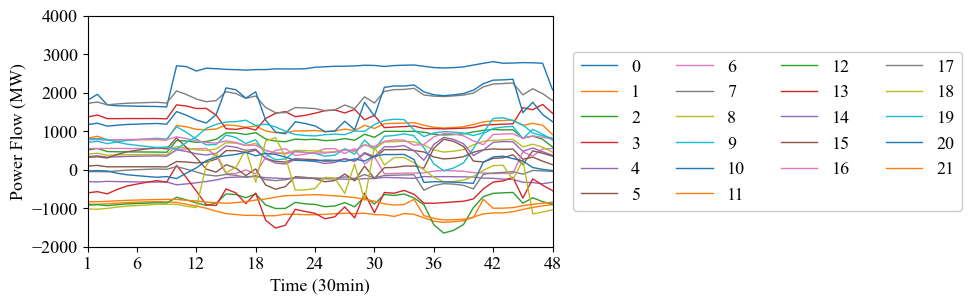

In [5]:
plt.figure(figsize=(6,3))
y = range(n_line)
x = range(n_time)
text1 = 13
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
for l in y:
    plt.plot(x, flow_sol[l], linewidth=1, label=l)
plt.tick_params(labelsize = text1)
plt.xlim(0,47)
plt.xticks(np.linspace(0,47,11), fontname = "Times New Roman")
plt.xticks([0,5,11,17,23,29,35,41,47],[1,6,12,18,24,30,36,42,48])
plt.yticks(np.linspace(-2000,4000,7), fontname = "Times New Roman")
plt.xlabel('Time (30min)', font1)
plt.ylabel("Power Flow (MW)", font1)
legend = plt.legend(loc='right', prop=font1, framealpha=1, ncol=4, bbox_to_anchor=(1.9, 0.5))
plt.show()

# Generation MIx

In [6]:
for t in instance.T:
    demand_sol[t] = sum(Dem_unit[d,t] for d in instance.Dem)
    
def deplicate_fun(x):
    return list(dict.fromkeys(x))
my_Gen_type = deplicate_fun(DG_type)
print(my_Gen_type)

Gen_Mix = np.zeros([len(my_Gen_type),n_time])
for gmix in range(len(my_Gen_type)):
    for g in range(n_dg):
        if my_Gen_type[gmix] == DG_type[g]:
            for t in range(n_time):
                Gen_Mix[gmix,t] += dg_sol[g,t]

for g in range(len(my_Gen_type)):
    print(my_Gen_type[g], sum(Gen_Mix[g,:]))
    
ev_charge = np.zeros([n_cs,n_time])
ev_discharge = np.zeros([n_cs,n_time])    
for k in range(n_cs):
    for t in range(n_time):
        if ev_sol[k,t] >= 0:
            ev_charge[k,t] = ev_sol[k,t]
        else:
            ev_discharge[k,t] = ev_sol[k,t]    
    
ev_charge_sol = np.sum(ev_charge, axis=0)
ev_discharge_sol = np.sum(ev_discharge, axis=0)
wind_sol = np.sum(res_sol[:8,:], axis=0)
solar_sol = np.sum(res_sol[-4:,:], axis=0)
ccgt_sol = Gen_Mix[0,:]
nuclear_sol = Gen_Mix[1,:]
chp_sol = Gen_Mix[2,:]
biomass_sol = Gen_Mix[3,:]
coal_sol = Gen_Mix[4,:]
ocgt_sol = Gen_Mix[5,:]
oil_sol = Gen_Mix[6,:]

print('EV Charge', np.sum(ev_charge_sol))
print('EV DisCharge', np.sum(ev_discharge_sol))
print('Wind', np.sum(wind_sol))
print('Solar', np.sum(solar_sol))

['CCGT', 'Nuclear', 'CHP', 'Biomass', 'Coal', 'OCGT', 'Oil']
CCGT 343839.1968279117
Nuclear 250464.0
CHP 188400.0
Biomass 58944.0
Coal 0.0
OCGT 0.0
Oil 0.0
EV Charge 0.0
EV DisCharge -26676.752467800274
Wind 337879.4164383562
Solar 71657.78495086347


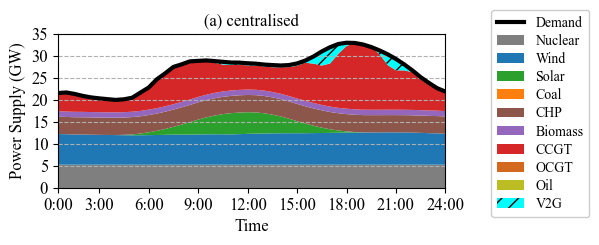

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,2))
sources = ['Nuclear', 'Wind', 'Solar', 'Coal', 'CHP', 'Biomass', 'CCGT', 'OCGT', 'Oil', 'V2G']
colors = ['tab:gray','tab:blue','tab:green','tab:orange','tab:brown','tab:purple','tab:red','chocolate','tab:olive','cyan']
x = range(48)
line_width = 3
space = 0.3
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
plt.plot(x, demand_sol, '-', color='black', label='Demand', linewidth=line_width)
stacks = plt.stackplot(x, nuclear_sol, wind_sol, solar_sol, coal_sol, chp_sol, biomass_sol, ccgt_sol, ocgt_sol, oil_sol,
                       [-i for i in ev_discharge_sol],
                       labels=sources, colors=colors)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,47,11), fontname = "Times New Roman")
plt.xticks([0,5,11,17,23,29,35,41,47],['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00'])
plt.yticks(np.linspace(0,35000,8), fontname = "Times New Roman")
plt.yticks([0,5000,10000,15000,20000,25000,30000,35000],[0,5,10,15,20,25,30,35])
plt.xlim([0,47])
plt.ylim([0,35000])
plt.ylabel('Power Supply (GW)', font2)
plt.xlabel('Time', font2)
plt.title('(a) centralised', font2)
hatches = ['','','','','','','','','','//']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
legend = plt.legend(loc='upper left', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1.1, 1.2))

plt.show()

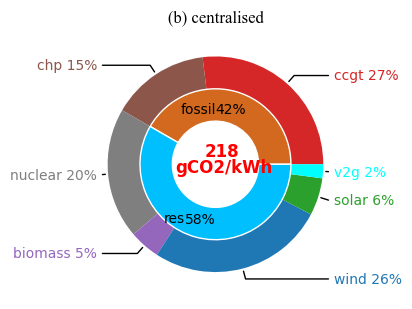

In [8]:
ccgt_tot, nuclear_tot, chp_tot, biomass_tot = sum(Gen_Mix[0,:]), sum(Gen_Mix[1,:]), sum(Gen_Mix[2,:]), sum(Gen_Mix[3,:])
coal_tot, ocgt_tot, oil_tot = sum(Gen_Mix[4,:]), sum(Gen_Mix[5,:]), sum(Gen_Mix[6,:])
wind_tot, solar_tot = np.sum(wind_sol), np.sum(solar_sol)
v2g_tot = -np.sum(ev_discharge_sol)

data = {'ccgt':ccgt_tot, 'chp':chp_tot, 
        'nuclear':nuclear_tot, 'biomass':biomass_tot, 'wind':wind_tot, 'solar':solar_tot, 'v2g':v2g_tot}
colors = ['tab:red','tab:brown','tab:gray','tab:purple','tab:blue','tab:green','cyan'] 

base_d = sum(list(data.values()))
final_data = {k:m/base_d*100 for k,m in data.items()}

fig, ax = plt.subplots(figsize=(7,3.5), subplot_kw=dict(aspect="equal"))
size = 0.3
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
recipe = list(final_data.keys())
data = list(final_data.values())
perc = [str(int(round(e / s * 100, 0))) + '%' for s in (sum(data),) for e in data]
wedges, texts = ax.pie(data, wedgeprops=dict(width=size), colors=colors)
kw = dict(arrowprops=dict(arrowstyle='-'), zorder=0, va='center')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i] + ' ' + perc[i], 
                xy=(x, y), 
                xytext=(1.1*np.sign(x), 1.1*y), 
                fontsize=text1,
                color=colors[i],
                horizontalalignment=horizontalalignment, 
                **kw)

data0 = [[coal_tot, oil_tot, ocgt_tot, ccgt_tot, chp_tot], [nuclear_tot, biomass_tot, wind_tot, solar_tot,v2g_tot]]
class0 = ['fossil', 'res']
color0 = ['chocolate', 'deepskyblue']
sums = [sum(i) for i in data0]
plt.pie(sums, radius=1-size, colors=color0, wedgeprops=dict(width=size, edgecolor='w'), autopct='%1.0f%%', pctdistance=0.75)
plt.text(0.370, 0.690, class0[0], color='black', fontsize=text1, transform=ax.transAxes)
plt.text(0.308, 0.284, class0[1], color='black', fontsize=text1, transform=ax.transAxes)

plt.text(0.46, 0.53, '218', weight='bold', color='red', fontsize=text2, transform=ax.transAxes)
plt.text(0.35, 0.47, 'gCO2/kWh', weight='bold', color='red', fontsize=text2, transform=ax.transAxes)
ax.set_title('(b) centralised', font2)

plt.show()

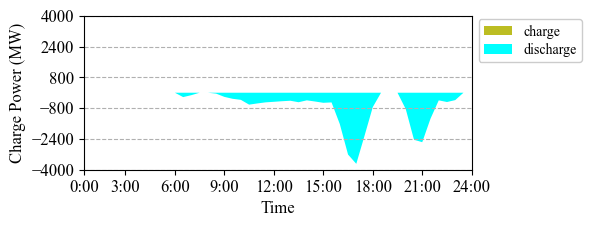

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,2))
sources = ['charge','discharge']
colors = ['tab:olive', 'cyan']
x = range(48)
space = 0.3
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
font3 = {'family': 'Times New Roman', 'weight': 'bold', 'size': text2}
stacks = plt.stackplot(x, ev_charge_sol, ev_discharge_sol, labels=sources, colors=colors)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,47,11), fontname = "Times New Roman")
plt.xticks([0,5,11,17,23,29,35,41,47],['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00'])
plt.yticks(np.linspace(-4000,4000,6), fontname = "Times New Roman")
plt.xlim([0,47])
plt.ylabel('Charge Power (MW)', font2)
plt.xlabel('Time', font2)
hatches = ['']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
legend = plt.legend(loc='upper left', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1.0, 1.025))

plt.show()

In [10]:
ev_c1_sol = np.zeros([n_ev,n_time])
ev_d1_sol = np.zeros([n_ev,n_time])
for t in instance.T:
    for i in instance.I:
        ev_c1_sol[i,t] = instance.ev_c[i,t].value 
        ev_d1_sol[i,t] = instance.ev_d[i,t].value 

In [11]:
ev_charge1_sol = np.sum(ev_c1_sol, axis=0)
ev_discharge1_sol = np.sum(ev_d1_sol, axis=0)

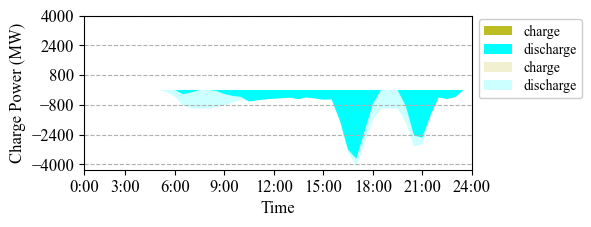

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,2))
sources = ['charge','discharge']
colors = ['tab:olive', 'cyan']
x = range(48)
space = 0.3
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
font3 = {'family': 'Times New Roman', 'weight': 'bold', 'size': text2}
stacks = plt.stackplot(x, ev_charge_sol, ev_discharge_sol, labels=sources, colors=colors)
stacks = plt.stackplot(x, ev_charge1_sol, -ev_discharge1_sol, alpha=0.2, labels=sources, colors=colors)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,47,11), fontname = "Times New Roman")
plt.xticks([0,5,11,17,23,29,35,41,47],['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00'])
plt.yticks(np.linspace(-4000,4000,6), fontname = "Times New Roman")
plt.xlim([0,47])
plt.ylabel('Charge Power (MW)', font2)
plt.xlabel('Time', font2)
hatches = ['']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
legend = plt.legend(loc='upper left', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1.0, 1.025))

plt.show()

# Carbon Intensity

In [13]:
Gen_Bus = np.concatenate((DG_bus, RES_bus, CS_bus), axis=0)
Gen_Day = np.vstack((dg_sol, res_sol, -ev_discharge)).T
RES_Carbon = np.zeros(n_res)
EV_Carbon = np.zeros(n_cs)
Gen_CF = np.concatenate((DG_Carbon, RES_Carbon, EV_Carbon), axis=0)

def calculate_carbon_intensity(time):
    # define terms
    P_CEFG = np.zeros([n_bus, n_dg+n_res+n_cs])
    e_CEFG = Gen_CF
    P_B = np.zeros([n_bus, n_bus])
    
    # calculate power generation for each bus
    Gen_t = Gen_Day[time]
    for b in range(n_bus):
        for g in range(len(Gen_Bus)):
            if b == Gen_Bus[g]:
                P_CEFG[b,g] = Gen_t[g]
            
    # calculate power flow
    for l in range(n_line):
        b = Line_top[l,0]
        p = Line_top[l,1]
        if flow_sol[l,time] >= 0:
            P_B[b,p] = flow_sol[l,time]
        else:
            P_B[p,b] = - flow_sol[l,time]
            
    # calculate carbon emission rates of power genenration
    r_CEFG = P_CEFG.dot(e_CEFG)
    
    # calculate the distribution of power inflows from both other buses and local generators 
    P_CEFT = np.diag( np.ones([1, n_bus+len(Gen_Bus)]).dot(np.vstack((P_B, P_CEFG.transpose())))[0] )
    
    # calculate bus carbon emission intensities
    e_CEFT = np.linalg.pinv(P_CEFT - P_B.transpose()).dot(r_CEFG)
    
    return e_CEFT

In [14]:
Bus_CI = []
for t in range(n_time):
    e_CEFT_time = calculate_carbon_intensity(t)
    Bus_CI.append(e_CEFT_time)
Bus_CI = np.array(Bus_CI)
print(Bus_CI.shape)
print('Max:', np.max(Bus_CI))
print('Min:', np.min(Bus_CI))
print('Sum:', np.sum(Bus_CI))
print('Averaged:', np.sum(Bus_CI)/(n_time*n_bus))

(48, 14)
Max: 378.6644622141633
Min: -8.852389237315745e-14
Sum: 78014.05293900915
Averaged: 116.09234068304934


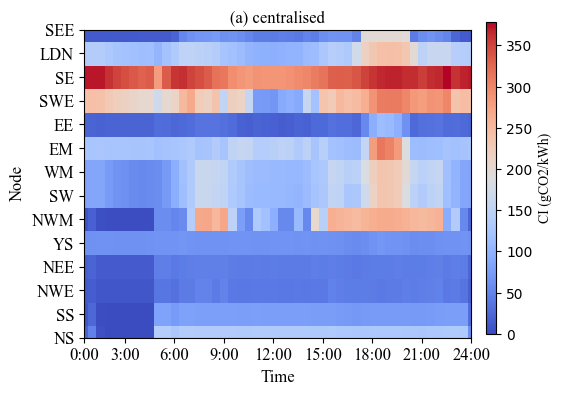

In [15]:
fig = plt.figure(figsize=(5,4))
grid = plt.GridSpec(1, 1, wspace=0.0, hspace=0.0)
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
cmap = plt.get_cmap('coolwarm')

ax = fig.add_subplot()
cmap = ax.imshow(Bus_CI.T, cmap, interpolation='nearest', aspect='auto')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,47,11), fontname = "Times New Roman")
plt.xticks([0,5,11,17,23,29,35,41,47],['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00'])
plt.yticks(np.linspace(0,13,14), fontname = "Times New Roman")
#plt.yticks([0,2,4,6,8,10,12],[1,3,5,7,9,11,13])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],
           ['NS', 'SS', 'NWE', 'NEE', 'YS', 'NWM', 'SW', 'WM', 'EM', 'EE', 'SWE', 'SE', 'LDN', 'SEE'])
ax.set_xlim (0,47)
ax.set_ylim (0,13)
ax.set_xlabel('Time', font2)
ax.set_ylabel('Node', font2)
ax.set_title('(a) centralised', font2)

cax = fig.add_axes([0.93,0.12,0.02,0.78])
cb = fig.colorbar(cmap, cax=cax, orientation='vertical', label='Carbon intensity (gCO2/kWh)')
cb.set_label('CI (gCO2/kWh)', fontdict=font1)
cb.ax.tick_params(labelsize=text1)
#cb.set_ticks(np.linspace(0,500,6))
#cb.set_ticklabels(['0','100','200','300','400','500'], fontname = 'Times New Roman')

plt.show()

# To Excel

In [16]:
dispatch_sol = np.array([nuclear_sol, wind_sol, solar_sol, chp_sol, biomass_sol, ccgt_sol,
                         [-i for i in ev_discharge_sol]])
genmix_sol = np.array([ccgt_tot, chp_tot, nuclear_tot, biomass_tot, wind_tot, solar_tot, v2g_tot])
ev_sol = np.array([ev_charge_sol, ev_discharge_sol])
excel_dispatch_data = pd.DataFrame(dispatch_sol)
excel_genmix_data = pd.DataFrame(genmix_sol)
excel_ev_data = pd.DataFrame(ev_sol)
excel_ci_data = pd.DataFrame(Bus_CI.T)

In [17]:
with pd.ExcelWriter('result_centralised.xlsx') as writer:
    excel_dispatch_data.to_excel(writer, sheet_name='dispatch', index=False)
    excel_genmix_data.to_excel(writer, sheet_name='genmix', index=False)
    excel_ev_data.to_excel(writer, sheet_name='ev', index=False)
    excel_ci_data.to_excel(writer, sheet_name="carbon", index=False)